<a href="https://colab.research.google.com/github/JeroenVanB/FruitClassification/blob/main/classify_fruit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit classification
## Refrences:
- https://www.tensorflow.org/tutorials/load_data/images
- https://www.tensorflow.org/tutorials/images/classification
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.kaggle.com/moltean/fruits


###Initialization Variables


In [ ]:
  # 1 = MobileNetV2
  # 2 = InceptionV3
  # 3 = ResNet50
ARCHITECTURES = [x for x in range(1,4)]
USE_DATA_AUGMENTATION = False
OPTIMIZERS = ["Adam", "AdaBelief"]

###Preprocessing


In [ ]:
USING_COLAB = True
!pip install adabelief-tf==0.2.0
from adabelief_tf import AdaBeliefOptimizer
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pathlib


In [ ]:
if USING_COLAB:
  from google.colab import drive
  drive.mount("/content/gdrive")
  !unzip '/content/gdrive/My Drive/Deep Learning/Dataset.zip'

data_dir = 'Dataset/'


Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/Dataset/Train/Pears/Pear 2/._244_100.jpg  
  inflating: Dataset/Train/Pears/Pear 2/r2_210_100.jpg  
  inflating: __MACOSX/Dataset/Train/Pears/Pear 2/._r2_210_100.jpg  
  inflating: Dataset/Train/Pears/Pear 2/254_100.jpg  
  inflating: __MACOSX/Dataset/Train/Pears/Pear 2/._254_100.jpg  
  inflating: Dataset/Train/Pears/Pear 2/r2_200_100.jpg  
  inflating: __MACOSX/Dataset/Train/Pears/Pear 2/._r2_200_100.jpg  
  inflating: Dataset/Train/Pears/Pear 2/r_225_100.jpg  
  inflating: __MACOSX/Dataset/Train/Pears/Pear 2/._r_225_100.jpg  
  inflating: Dataset/Train/Pears/Pear 2/r2_192_100.jpg  
  inflating: __MACOSX/Dataset/Train/Pears/Pear 2/._r2_192_100.jpg  
  inflating: Dataset/Train/Pears/Pear 2/r2_182_100.jpg  
  inflating: __MACOSX/Dataset/Train/Pears/Pear 2/._r2_182_100.jpg  
  inflating: Dataset/Train/Pears/Pear 2/r2_34_100.jpg  
  inflating: __MACOSX/Dataset/Train/Pears/Pear 2/._r2_34_100.jpg  
  inflating: Datase

In [ ]:
train_dir = pathlib.Path(data_dir + 'Train')
BATCH_SIZE = 32
IMG_SIZE = (100,100)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path(data_dir + 'Test'),
    shuffle=True,
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)
num_of_classes = len(class_names)


Found 33940 files belonging to 11 classes.
Using 27152 files for training.
Found 33940 files belonging to 11 classes.
Using 6788 files for validation.
Found 11357 files belonging to 11 classes.
['Apples', 'Bananas', 'Cherries', 'Grapes', 'Onions', 'Peaches', 'Pears', 'Peppers', 'Plums', 'Potatoes', 'Tomatoes']


###Visualize data

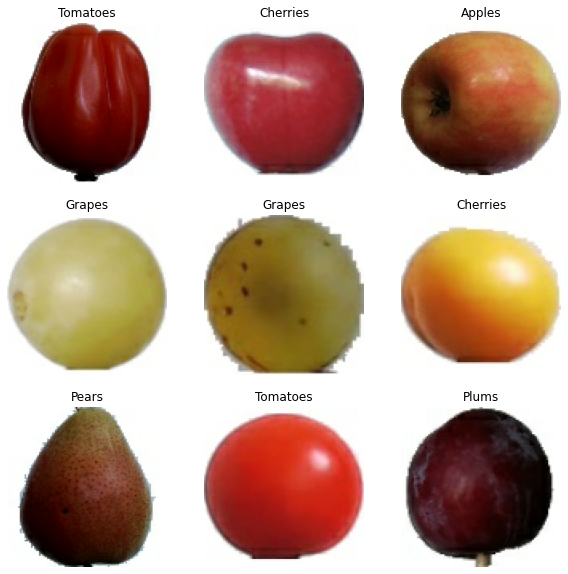

In [ ]:
def plot_images():
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
plot_images()

###Data performance/caching and augmentation

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

(32, 100, 100, 3)
(32,)


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomZoom(height_factor=(0, 0.3), fill_mode='constant', fill_value=255),
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  # tf.keras.layers.experimental.preprocessing.RandomCrop(100,100),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='constant', fill_value=255),
])

### Setup and training

In [ ]:
EPOCHS = 10
IMG_SHAPE = IMG_SIZE + (3,)
results = []
data_augmentation_options = [True, False]

for arch in ARCHITECTURES:
  for opt in OPTIMIZERS:
    for use_data_augmentation in data_augmentation_options:

      if opt == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-07)
      else:
        optimizer = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-07, rectify=False)

      if arch == 1: # MobileNetV2
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')
      elif arch == 2: # Inception V3
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input
        base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')
      elif arch == 3: # ResNet50
        preprocess_input = tf.keras.applications.resnet.preprocess_input
        base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                      include_top=False,
                                                      weights='imagenet')

      # This feature extractor will convert each 100x100x3 image into a 5x5x1280 block of features
      image_batch, label_batch = next(iter(train_ds))
      feature_batch = base_model(image_batch)
      # print(feature_batch.shape)

      base_model.trainable = False

      global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
      feature_batch_average = global_average_layer(feature_batch)
      # print(feature_batch_average.shape)

      prediction_layer = tf.keras.layers.Dense(num_of_classes,)
      prediction_batch = prediction_layer(feature_batch_average)
      # print(prediction_batch.shape)

      inputs = tf.keras.Input(shape=(100, 100, 3))
      x = inputs
      if use_data_augmentation:
        x = data_augmentation(inputs)
      x = preprocess_input(x)
      x = base_model(x, training=False)
      x = global_average_layer(x)
      x = tf.keras.layers.Dropout(0.2)(x)
      outputs = prediction_layer(x)
      model = tf.keras.Model(inputs, outputs)

      early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min',
                                                    restore_best_weights=True)
      model.compile(
        optimizer=optimizer,
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

      print(f'### Training with arch {arch}, opt {opt}, data_augmentation= {use_data_augmentation}')
      # Training the model
      model_history = model.fit(train_ds,
                      epochs=EPOCHS,
                      validation_data=val_ds,
                      callbacks=[early_stopping],
                      verbose=1)

      # Evaluation after training (val_ds)
      loss, accuracy = model.evaluate(test_ds)

      result = {'arch': arch, 
                'optimizer': opt, 
                'data_augmentation': use_data_augmentation, 
                'history': model_history,
                'loss': loss,
                'accuracy': accuracy}
      results.append(result)

### Training with arch 1, opt Adam, data_augmentation= [True, False]
Epoch 1/10
849/849 [==============================] - 24s 26ms/step - loss: 0.7464 - accuracy: 0.7563 - val_loss: 0.1086 - val_accuracy: 0.9673
Epoch 2/10
849/849 [==============================] - 21s 25ms/step - loss: 0.1320 - accuracy: 0.9551 - val_loss: 0.0832 - val_accuracy: 0.9723
Epoch 3/10
849/849 [==============================] - 21s 25ms/step - loss: 0.0893 - accuracy: 0.9729 - val_loss: 0.0613 - val_accuracy: 0.9801
Epoch 4/10
849/849 [==============================] - 21s 25ms/step - loss: 0.0780 - accuracy: 0.9732 - val_loss: 0.0702 - val_accuracy: 0.9748
Epoch 5/10
849/849 [==============================] - 21s 25ms/step - loss: 0.0682 - accuracy: 0.9762 - val_loss: 0.0543 - val_accuracy: 0.9823
Epoch 6/10
849/849 [==============================] - 21s 25ms/step - loss: 0.0639 - accuracy: 0.9772 - val_loss: 0.0602 - val_accuracy: 0.9780
Epoch 7/10
849/849 [==============================] - 21s 25ms/step

####Important note about BatchNormalization layers
[TF Source.](https://www.tensorflow.org/tutorials/images/transfer_learning#important_note_about_batchnormalization_layers)
Many models contain tf.keras.layers.BatchNormalization layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set layer.trainable = False, the BatchNormalization layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [ ]:
inputs = tf.keras.Input(shape=(100, 100, 3))
if USE_DATA_AUGMENTATION:
  x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 100, 100, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 100, 100, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

In [ ]:
initial_epochs = 10

# Evaluation before training (val_ds)
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss (on val_ds): {:.2f}".format(loss0))
print("initial accuracy (on val_ds): {:.2f}".format(accuracy0))

# Training the model
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

# Evaluation after training (val_ds)
loss1, accuracy1 = model.evaluate(val_ds)
print("after training loss (on val_ds): {:.2f}".format(loss1))
print("after training accuracy (on val_ds): {:.2f}".format(accuracy1))

213/213 [==============================] - 10s 39ms/step - loss: 4.0633 - accuracy: 0.0555
initial loss (on val_ds): 4.01
initial accuracy (on val_ds): 0.06
Epoch 1/10
849/849 [==============================] - 37s 40ms/step - loss: 1.0533 - accuracy: 0.6539 - val_loss: 0.3921 - val_accuracy: 0.8885
Epoch 2/10
849/849 [==============================] - 32s 38ms/step - loss: 0.3457 - accuracy: 0.8928 - val_loss: 0.2099 - val_accuracy: 0.9487
Epoch 3/10
849/849 [==============================] - 32s 38ms/step - loss: 0.2120 - accuracy: 0.9390 - val_loss: 0.1426 - val_accuracy: 0.9682
Epoch 4/10
849/849 [==============================] - 33s 38ms/step - loss: 0.1519 - accuracy: 0.9588 - val_loss: 0.1013 - val_accuracy: 0.9803
Epoch 5/10
849/849 [==============================] - 32s 38ms/step - loss: 0.1137 - accuracy: 0.9715 - val_loss: 0.0789 - val_accuracy: 0.9835
Epoch 6/10
849/849 [==============================] - 32s 38ms/step - loss: 0.0875 - accuracy: 0.9791 - val_loss: 0.0635 - 

#### Learning curves plot

In [ ]:
print(results)

newResults = []
for res in results:
  res['history'] = res['history'].history
  newResults.append(res)

print(newResults)
mobileNetV2 = [x for x in results if x['arch'] == 1]
inceptionV3 = [x for x in results if x['arch'] == 2]
ResNet50 = [x for x in results if x['arch'] == 3]

import pickle
pickle.dump(newResults, open('results.p', 'wb'))

[{'arch': 1, 'optimizer': 'Adam', 'data_augmentation': True, 'history': <tensorflow.python.keras.callbacks.History object at 0x7f0be9a8d1d0>, 'loss': 0.10324516892433167, 'accuracy': 0.9634586572647095}, {'arch': 1, 'optimizer': 'Adam', 'data_augmentation': False, 'history': <tensorflow.python.keras.callbacks.History object at 0x7f0be7ca7cd0>, 'loss': 0.08583375811576843, 'accuracy': 0.984062671661377}, {'arch': 1, 'optimizer': 'AdaBelief', 'data_augmentation': True, 'history': <tensorflow.python.keras.callbacks.History object at 0x7f0cd59782d0>, 'loss': 0.1355937123298645, 'accuracy': 0.9535968899726868}, {'arch': 1, 'optimizer': 'AdaBelief', 'data_augmentation': False, 'history': <tensorflow.python.keras.callbacks.History object at 0x7f0bebe1b110>, 'loss': 0.07993455231189728, 'accuracy': 0.9816852807998657}, {'arch': 2, 'optimizer': 'Adam', 'data_augmentation': True, 'history': <tensorflow.python.keras.callbacks.History object at 0x7f0be6a6e790>, 'loss': 0.35066118836402893, 'accura

[{'arch': 1, 'optimizer': 'Adam', 'data_augmentation': True, 'history': {'loss': [0.3738037943840027, 0.11914827674627304, 0.0880364328622818, 0.07387354969978333, 0.06160641089081764, 0.05846069008111954, 0.05850663036108017, 0.05358497053384781, 0.05468989908695221, 0.048853665590286255], 'accuracy': [0.8747053742408752, 0.9599292874336243, 0.9728565216064453, 0.9745506644248962, 0.9791175723075867, 0.9798910021781921, 0.9800014495849609, 0.9814010262489319, 0.9811063408851624, 0.9828005433082581], 'val_loss': [0.10862606018781662, 0.083219014108181, 0.061279043555259705, 0.07021817564964294, 0.05426523834466934, 0.06022476404905319, 0.05157596617937088, 0.0738065093755722, 0.034851815551519394, 0.028744414448738098], 'val_accuracy': [0.967295229434967, 0.9723040461540222, 0.9801119565963745, 0.9748085141181946, 0.9823217391967773, 0.9780495166778564, 0.9804065823554993, 0.9712728261947632, 0.9889510869979858, 0.9904242753982544]}, 'loss': 0.10324516892433167, 'accuracy': 0.963458657

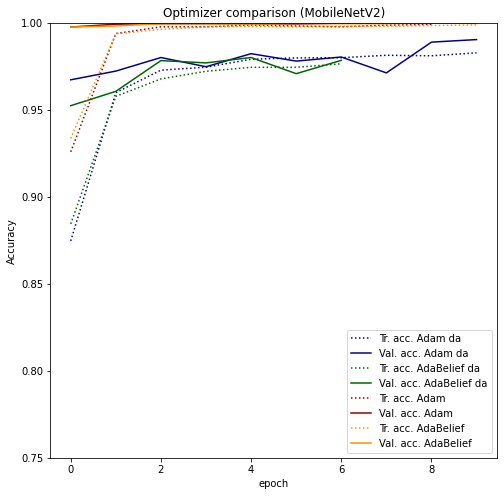

[{'arch': 2, 'optimizer': 'Adam', 'data_augmentation': True, 'history': {'loss': [0.6497251987457275, 0.3661198914051056, 0.3331257700920105, 0.3003092110157013, 0.289437472820282, 0.29451873898506165, 0.2798862159252167, 0.2819552719593048], 'accuracy': [0.7752651572227478, 0.8683706521987915, 0.8840969204902649, 0.8952931761741638, 0.8976134061813354, 0.8982763886451721, 0.9039849638938904, 0.9020698070526123], 'val_loss': [0.4027622640132904, 0.3671465814113617, 0.27799510955810547, 0.2688189744949341, 0.2958579659461975, 0.25958046317100525, 0.28846612572669983, 0.30572277307510376], 'val_accuracy': [0.8516499996185303, 0.8681496977806091, 0.9026222825050354, 0.9086623191833496, 0.8961402177810669, 0.9133765697479248, 0.9049793481826782, 0.8974661231040955]}, 'loss': 0.35066118836402893, 'accuracy': 0.8791053891181946}, {'arch': 2, 'optimizer': 'AdaBelief', 'data_augmentation': True, 'history': {'loss': [0.631305456161499, 0.3798622488975525, 0.337154358625412, 0.3271395266056061, 

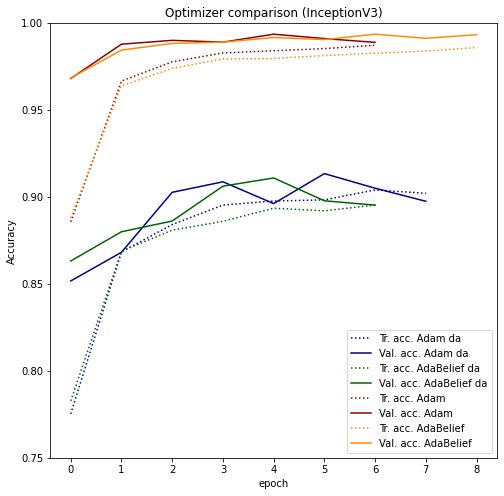

[{'arch': 3, 'optimizer': 'Adam', 'data_augmentation': True, 'history': {'loss': [0.2945101857185364, 0.0748029351234436, 0.0473734512925148, 0.041132256388664246, 0.03355494886636734, 0.028947222977876663, 0.026249565184116364, 0.02331482246518135, 0.025923537090420723], 'accuracy': [0.9041323065757751, 0.9778285026550293, 0.9873305559158325, 0.9877356886863708, 0.9895035624504089, 0.9903874397277832, 0.9914923310279846, 0.992449939250946, 0.9913450479507446], 'val_loss': [0.10020488500595093, 0.05374478921294212, 0.0497112013399601, 0.04491668567061424, 0.03663329407572746, 0.054821085184812546, 0.019525760784745216, 0.022284775972366333, 0.02596042864024639], 'val_accuracy': [0.9678844809532166, 0.9840895533561707, 0.9835003018379211, 0.9864466786384583, 0.9870359301567078, 0.9779021739959717, 0.9935179948806763, 0.9930760264396667, 0.9911608695983887]}, 'loss': 0.1042022556066513, 'accuracy': 0.9666284918785095}, {'arch': 3, 'optimizer': 'AdaBelief', 'data_augmentation': True, 'his

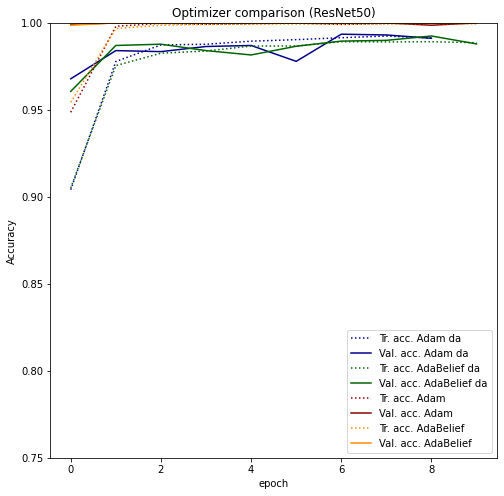

In [77]:
import pickle

with open('results.p', 'rb') as f:
    data = pickle.load(f)

for arch in range(1,4):
    for d in data:
      if d['arch'] == arch and d['optimizer'] == 'Adam' and d['data_augmentation']:
        d_adam_data_aug = d
      if d['arch'] == arch and d['optimizer'] == 'AdaBelief' and d['data_augmentation']:
        d_adabelief_data_aug = d
      if d['arch'] == arch and d['optimizer'] == 'Adam' and not d['data_augmentation']:
        d_adam_no_data_aug = d
      if d['arch'] == arch and d['optimizer'] == 'AdaBelief' and not d['data_augmentation']:
        d_adabelief_no_data_aug = d
      
    plot_history(arch, [d_adam_data_aug, d_adabelief_data_aug, d_adam_no_data_aug, d_adabelief_no_data_aug])
    # plot_history(arch, [d_adam_no_data_aug, d_adabelief_no_data_aug])
    

In [76]:
import matplotlib.pyplot as plt
c1 = ['lightblue', 'lightgreen', 'salmon', 'orange']
c = ['darkblue', 'darkgreen', 'darkred', 'darkorange']
archs = ['', 'MobileNetV2', 'InceptionV3', 'ResNet50']
def plot_history(arch, data):
    print(data)
    print(arch)
    arch_name = archs[arch]

    # for d in data:
    #   opt_name = d['optimizer']
    #   history = d['history']
    #   acc = history['accuracy']
    #   val_acc = history['val_accuracy']
    #   loss = history['loss']
    #   val_loss = history['val_loss']  

    plt.figure(figsize=(8, 8))
    # plt.subplot(2, 1, 1)
    for idx, d in enumerate(data):
      opt_name = d['optimizer']
      history = d['history']
      acc = history['accuracy']
      val_acc = history['val_accuracy']
      loss = history['loss']
      val_loss = history['val_loss'] 
      aug = ' da' if d['data_augmentation'] else ''

      plt.plot(acc, label=f'Tr. acc. {opt_name}{aug}', color=c[idx], linestyle='dotted')
      plt.plot(val_acc, label=f'Val. acc. {opt_name}{aug}', color=c[idx])
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([0.75,1])
    # aug = ' with data augmentation' if d['data_augmentation'] else ''
    # plt.title(f'Optimizer comparison ({arch_name}{aug})')
    plt.title(f'Optimizer comparison ({arch_name})')
    plt.xlabel('epoch')


    # plt.subplot(2, 1, 2)
    # for d in data:
    #   opt_name = d['optimizer']
    #   aug = 'da' if d['data_augmentation'] else ''
    #   history = d['history']
    #   acc = history['accuracy']
    #   val_acc = history['val_accuracy']
    #   loss = history['loss']
    #   val_loss = history['val_loss'] 
    #   plt.plot(loss, label=f'Tr. loss {arch_name} {opt_name} {aug}')
    #   plt.plot(val_loss, label=f'Val. loss {arch_name} {opt_name} {aug}')
    # plt.legend(loc='upper right')
    # plt.ylabel('Cross Entropy')
    # plt.ylim([0,1])
    # plt.title('Training and Validation Loss')
    # plt.xlabel('epoch')
    plt.show()

#### Important note about difference in validation metrics
If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

In [48]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
print(label_batch)
predictions = model.predict_on_batch(image_batch)
score = tf.nn.softmax(predictions[0])

# print(label_batch[0])
# print(score)

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

plt.figure(figsize=(10, 10))
for i in range(9):
  score = tf.nn.softmax(predictions[i])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[np.argmax(score)] + ' ({:.2f}%)'.format(100 * np.max(score)))
  plt.axis("off")



NameError: ignored